In [ ]:
!pip install psutil

In [ ]:
import pandas as pd
import numpy as np
import warnings
import tracemalloc
import time
import psutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras import layers
from keras.layers import Input, Dense, ReLU, Normalization, LSTM, GRU, Reshape, TimeDistributed, Conv1D, Dropout, Flatten, Bidirectional, LeakyReLU, SimpleRNN,BatchNormalization
from keras.activations import tanh
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

pd.set_option('display.max_columns', None)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


warnings.filterwarnings("ignore")

Num GPUs Available:  1


# CIC IOT 2023 Dataset



*   10 percent of total dataset, class balances remain the same
*   contains 33 labels, condensed into 8 sub classes... will be further put into 2 classes.









In [ ]:
iotData = pd.read_csv('/content/drive/MyDrive/AnomalyDetectionDataset/CICIOT2023.csv')
iotData

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,http,https,dns,telnet,smtp,ssh,irc,tcp,udp,dhcp,arp,icmp,ipv,llc,tot_sum,min,max,avg,std,tot_size,iat,number,radius,covariance,variance,weight,label,magnitude
0,0.000000,54,TCP,64.00,26,26,0.0,False,True,False,False,False,False,False,0.00,1.00,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,82972984.0,9.5,0.000000,0.000000e+00,0.00,141.55,DoS,10.392304
1,0.000210,54,TCP,63.84,22,22,0.0,False,False,False,False,False,False,False,0.00,0.02,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,568.60,54.00,55.60,54.098907,0.384222,54.20,83033410.0,9.5,0.544886,1.862815e+00,0.08,141.55,DDoS,10.401817
2,24.129251,375724,TCP,99.10,50,50,0.0,False,False,False,False,True,False,False,0.00,1.40,0,113,511,False,True,False,False,False,False,False,True,False,False,False,False,True,True,29081.20,70.00,7306.00,1915.092000,1732.470300,1438.50,166526050.0,13.5,2451.181000,3.007613e+06,1.00,244.60,Benign,61.926430
3,0.000000,0,ICMP,64.00,11,11,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,True,True,441.00,42.00,42.00,42.000000,0.000000,42.00,83128640.0,9.5,0.000000,0.000000e+00,0.00,141.55,DDoS,9.165152
4,0.000000,54,TCP,64.00,1,1,0.0,False,True,False,False,False,False,False,0.00,1.00,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,83089736.0,9.5,0.000000,0.000000e+00,0.00,141.55,DDoS,10.392304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4668648,0.000000,0,ICMP,64.00,6,6,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,True,True,441.00,42.00,42.00,42.000000,0.000000,42.00,83127800.0,9.5,0.000000,0.000000e+00,0.00,141.55,DDoS,9.165152
4668649,0.048687,26,RSVP,65.68,2,2,0.0,False,False,False,False,False,False,False,0.01,0.07,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,5976.20,507.60,578.00,570.680360,21.036430,568.40,83651410.0,9.5,29.796936,3.001094e+03,0.15,141.55,Mirai,33.778870
4668650,0.000000,54,TCP,64.00,11,11,0.0,True,False,True,False,False,False,False,1.00,0.00,1,0,0,True,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,83345050.0,9.5,0.000000,0.000000e+00,0.00,141.55,DDoS,10.392304
4668651,0.098741,34776,CHAOS,71.64,7044,7044,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,534.20,50.00,54.80,50.706910,1.671482,50.80,83011440.0,9.5,2.367731,1.185735e+01,0.24,141.55,DoS,10.069780


In [ ]:
iotData['label'].value_counts()

DDoS          3398438
DoS            809091
Mirai          263398
Benign         109824
Spoofing        48659
Recon           35453
Web              2487
BruteForce       1303
Name: label, dtype: int64

In [ ]:
def change_label(df):
    df.label.replace(['DoS', 'DDoS','Mirai', 'Spoofing', 'Recon', 'Web','BruteForce'], 1, inplace=True)
    df.label.replace(['Benign'], 0, inplace=True)
    return df
iotData = change_label(iotData)

In [ ]:
iotData.label.value_counts()

1    4558829
0     109824
Name: label, dtype: int64

In [ ]:
iotData_y = iotData['label']
iotData_y

0          1
1          1
2          0
3          1
4          1
          ..
4668648    1
4668649    1
4668650    1
4668651    1
4668652    1
Name: label, Length: 4668653, dtype: int64

In [ ]:
iotData_x = iotData.drop(['label'], axis=1)
iotData_x

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,http,https,dns,telnet,smtp,ssh,irc,tcp,udp,dhcp,arp,icmp,ipv,llc,tot_sum,min,max,avg,std,tot_size,iat,number,radius,covariance,variance,weight,magnitude
0,0.000000,54,TCP,64.00,26,26,0.0,False,True,False,False,False,False,False,0.00,1.00,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,82972984.0,9.5,0.000000,0.000000e+00,0.00,141.55,10.392304
1,0.000210,54,TCP,63.84,22,22,0.0,False,False,False,False,False,False,False,0.00,0.02,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,568.60,54.00,55.60,54.098907,0.384222,54.20,83033410.0,9.5,0.544886,1.862815e+00,0.08,141.55,10.401817
2,24.129251,375724,TCP,99.10,50,50,0.0,False,False,False,False,True,False,False,0.00,1.40,0,113,511,False,True,False,False,False,False,False,True,False,False,False,False,True,True,29081.20,70.00,7306.00,1915.092000,1732.470300,1438.50,166526050.0,13.5,2451.181000,3.007613e+06,1.00,244.60,61.926430
3,0.000000,0,ICMP,64.00,11,11,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,True,True,441.00,42.00,42.00,42.000000,0.000000,42.00,83128640.0,9.5,0.000000,0.000000e+00,0.00,141.55,9.165152
4,0.000000,54,TCP,64.00,1,1,0.0,False,True,False,False,False,False,False,0.00,1.00,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,83089736.0,9.5,0.000000,0.000000e+00,0.00,141.55,10.392304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4668648,0.000000,0,ICMP,64.00,6,6,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,True,True,441.00,42.00,42.00,42.000000,0.000000,42.00,83127800.0,9.5,0.000000,0.000000e+00,0.00,141.55,9.165152
4668649,0.048687,26,RSVP,65.68,2,2,0.0,False,False,False,False,False,False,False,0.01,0.07,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,5976.20,507.60,578.00,570.680360,21.036430,568.40,83651410.0,9.5,29.796936,3.001094e+03,0.15,141.55,33.778870
4668650,0.000000,54,TCP,64.00,11,11,0.0,True,False,True,False,False,False,False,1.00,0.00,1,0,0,True,False,False,False,False,False,False,True,False,False,False,False,True,True,567.00,54.00,54.00,54.000000,0.000000,54.00,83345050.0,9.5,0.000000,0.000000e+00,0.00,141.55,10.392304
4668651,0.098741,34776,CHAOS,71.64,7044,7044,0.0,False,False,False,False,False,False,False,0.00,0.00,0,0,0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,534.20,50.00,54.80,50.706910,1.671482,50.80,83011440.0,9.5,2.367731,1.185735e+01,0.24,141.55,10.069780


In [ ]:
categorical_features = ['protocol_type']
x_categorical = iotData_x[categorical_features]
x_continuous = iotData_x.drop(categorical_features, axis=1)

#SCALE CONTINUOUS
continuous_features = x_continuous.columns
scaler = MinMaxScaler(feature_range=(0, 1))
x_continuous_scaled = scaler.fit_transform(x_continuous)
x_continuous_scaled = pd.DataFrame(x_continuous_scaled, columns=x_continuous.columns)
#ENCODE CATEGORICAL
encoder = OneHotEncoder(sparse=False)
x_categorical_encoded = encoder.fit_transform(x_categorical)
encoded_columns = encoder.get_feature_names_out(x_categorical.columns)
x_categorical_encoded = pd.DataFrame(x_categorical_encoded, columns=encoded_columns)

#Combine Back Together
processed_dataset = pd.concat([x_categorical_encoded, x_continuous_scaled,iotData_y], axis=1)

#Train_Test_Split for supervised data
y_supervised = processed_dataset['label']
x_supervised = processed_dataset.drop(['label'], axis=1)
x_supervised_train, x_supervised_test, y_supervised_train, y_supervised_test = train_test_split(x_supervised,y_supervised, test_size=0.2, random_state=42)
x_supervised_val, x_supervised_val, y_supervised_val, y_supervised_val = train_test_split(x_supervised_train, y_supervised_train, test_size=0.2, random_state=42)

In [ ]:
x_supervised

,protocol_type_3PC,protocol_type_ARGUS (deprecated),protocol_type_BBN-RCC-MON,protocol_type_CBT,protocol_type_CHAOS,protocol_type_DCCP,protocol_type_DCN-MEAS,protocol_type_DDP,protocol_type_EGP,protocol_type_EMCON,protocol_type_GGP,protocol_type_GRE,protocol_type_HMP,protocol_type_HOPOPT,protocol_type_ICMP,protocol_type_IDPR,protocol_type_IDPR-CMTP,protocol_type_IDRP,protocol_type_IGMP,protocol_type_IGP,protocol_type_IL,protocol_type_IPv4,protocol_type_IPv6,protocol_type_IPv6-Frag,protocol_type_IPv6-Route,protocol_type_IRTP,protocol_type_ISO-TP4,protocol_type_LEAF-1,protocol_type_LEAF-2,protocol_type_MERIT-INP,protocol_type_MFE-NSP,protocol_type_MUX,protocol_type_NETBLT,protocol_type_NVP-II,protocol_type_PRM,protocol_type_PUP,protocol_type_RDP,protocol_type_RSVP,protocol_type_SDRP,protocol_type_ST,protocol_type_TCP,protocol_type_TP++,protocol_type_TRUNK-1,protocol_type_TRUNK-2,protocol_type_UDP,protocol_type_XNET,protocol_type_XNS-IDP,protocol_type_XTP,flow_duration,header_length,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,http,https,dns,telnet,smtp,ssh,irc,tcp,udp,dhcp,arp,icmp,ipv,llc,tot_sum,min,max,avg,std,tot_size,iat,number,radius,covariance,variance,weight,magnitude
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000005,0.250980,3.099442e-06,3.099442e-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.077700,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.004124,0.002230,0.000376,0.001154,0.000000,0.001278,0.494949,0.607143,0.000000,0.000000e+00,0.00,0.57697,0.009198
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.314457e-10,0.000005,0.250353,2.622604e-06,2.622604e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001554,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.004137,0.002230,0.000427,0.001163,0.000049,0.001299,0.495310,0.607143,0.000049,3.033223e-08,0.08,0.57697,0.009269
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.118628e-05,0.038083,0.388627,5.960464e-06,5.960464e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.108780,0.000000,0.02773,0.053363,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.228127,0.005203,0.227854,0.180101,0.222254,0.148749,0.993359,0.892857,0.221892,4.897298e-02,1.00,1.00000,0.395447
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.250980,1.311302e-06,1.311302e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.003134,0.000000,0.000000,0.000000,0.000000,0.000000,0.495878,0.607143,0.000000,0.000000e+00,0.00,0.57697,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000005,0.250980,1.192093e-07,1.192093e-07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.077700,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.004124,0.002230,0.000376,0.001154,0.000000,0.001278,0.495646,0.607143,0.000000,0.000000e+00,0.00,0.57697,0.009198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# **NSL-KDD DATASET**

In [ ]:
#LOAD NSL-KDD DATASET
data1 = pd.read_csv('/content/drive/MyDrive/NSL-KDD Dataset/KDDTrain+.txt')
data2 = pd.read_csv('/content/drive/MyDrive/NSL-KDD Dataset/KDDTest+.txt')
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

data1.columns = columns
data2.columns = columns
data = data1.append(data2)
data = data.drop('level', axis=1)
display(data)

y = data[['attack']]
print(y.attack.value_counts())
x = data.drop(['attack'], axis=1)
x.su_attempted.replace(2, 0, inplace=True)


def change_label(df):
    df.attack.replace(['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop',
                       'udpstorm', 'worm'], 1, inplace=True)
    df.attack.replace(['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail',
                       'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop'], 1, inplace=True)
    df.attack.replace(['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'], 1, inplace=True)
    df.attack.replace(['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'], 1, inplace=True)
    df.attack.replace(['normal'], 0, inplace=True)
    return df
change_label(y)
y.attack.value_counts()

categorical_features = ['protocol_type', 'service', 'flag']
binary_features = ['logged_in', 'is_guest_login', 'is_host_login', 'land','root_shell','su_attempted']
column_to_drop = ['num_outbound_cmds']
x_categorical = x[categorical_features]
x_binary = x[binary_features]
x_continuous = x.drop(categorical_features + binary_features + column_to_drop, axis=1)

#SCALE CONTINUOUS
continuous_features = x_continuous.columns
scaler = MinMaxScaler(feature_range=(0, 1))
x_continuous_scaled = scaler.fit_transform(x_continuous)
x_continuous_scaled = pd.DataFrame(x_continuous_scaled, columns=x_continuous.columns)

#ENCODE CATEGORICAL
encoder = OneHotEncoder(sparse=False)
x_categorical_encoded = encoder.fit_transform(x_categorical)
encoded_columns = encoder.get_feature_names_out(x_categorical.columns)
x_categorical_encoded = pd.DataFrame(x_categorical_encoded, columns=encoded_columns)

# Resetting indexes of each DataFrame
x_categorical_encoded = x_categorical_encoded.reset_index(drop=True)
x_continuous_scaled = x_continuous_scaled.reset_index(drop=True)
x_binary = x_binary.reset_index(drop=True)
y = y.reset_index(drop=True)

#Combine Back Together
processed_dataset = pd.concat([x_categorical_encoded, x_continuous_scaled, x_binary, y], axis=1)

#Train_Test_Split for supervised data
y_supervised = processed_dataset['attack']
x_supervised = processed_dataset.drop(['attack'], axis=1)
x_supervised_train, x_supervised_test, y_supervised_train, y_supervised_test = train_test_split(x_supervised,y_supervised, test_size=0.2, random_state=42)
x_supervised_val, x_supervised_val, y_supervised_val, y_supervised_val = train_test_split(x_supervised_train, y_supervised_train, test_size=0.2, random_state=42)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal
22539,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.0,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal
22540,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.0,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back
22541,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.0,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal


normal             77053
neptune            45870
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
ftp_write             11
loadmodule            11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [ ]:
x_supervised

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,logged_in,is_guest_login,is_host_login,land,root_shell,su_attempted
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.025440,0.001957,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.240705,0.011742,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.009785,0.009785,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,0,0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.058708,0.062622,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Additional Processing for AutoEncoder

In [ ]:
processed_dataset_scaled = scaler.fit_transform(processed_dataset)
processed_dataset_scaled = pd.DataFrame(processed_dataset_scaled, columns = processed_dataset.columns)

#Split into training and testing for unsupervised
x_train, x_test= train_test_split(processed_dataset, test_size=0.2, random_state=42)

print('X_TRAIN:\n', x_train.attack.value_counts())
print('X_TEST:\n', x_test.attack.value_counts())

normal_data_train=x_train[x_train['attack'] == 0]
normal_data_train=normal_data_train.drop(['attack'], axis = 1)

abnormal_data_train = x_train[x_train['attack'] == 1]
abnormal_data_train=abnormal_data_train.drop(['attack'], axis = 1)

normal_data_train, normal_data_val = train_test_split(normal_data_train, test_size=0.2, random_state=42)
abnormal_data_train, abnormal_data_val = train_test_split(abnormal_data_train, test_size=0.2, random_state=42)

data_test=x_test.drop(['attack'], axis=1)


X_TRAIN:
 0    61696
1    57116
Name: attack, dtype: int64
X_TEST:
 0    15357
1    14346
Name: attack, dtype: int64


# **5G NIDD DATASET**

In [ ]:
#5G NIDD DATASET
dataset = pd.read_csv('/content/drive/MyDrive/AnomalyDetectionDataset/5G-NIDD.csv')
columns_to_drop = [col for col in dataset if dataset[col].nunique() == 1]
redundant_columns = ['Unnamed: 0', 'RunTime', 'Mean', 'Sum', 'Min', 'Max']
too_much_nan_columns = ['dTos', 'dDSb', 'dTtl', 'dHops', 'SrcGap', 'DstGap', 'SrcWin', 'DstWin', 'sVid', 'dVid', 'SrcTCPBase', 'DstTCPBase']
columns_to_drop.extend(redundant_columns)
columns_to_drop.extend(too_much_nan_columns)
dataset.drop(columns=columns_to_drop, axis=1, inplace=True)
remaining_nan_columns = ['sTos', 'sTtl', 'sHops']

for col in remaining_nan_columns:
  col_mean = dataset[col].mean()
  dataset[col].fillna(col_mean, inplace=True)

y = dataset[['Label']]
y.Label.replace(['Benign'], 0, inplace=True)
y.Label.replace(['Malicious'], 1, inplace=True)
print(y.Label.value_counts())
x = dataset.drop(['Label', 'Attack Type', 'Attack Tool'], axis=1)

categorical_features = ['Cause', 'Proto', 'State', 'sDSb']
x_categorical = x[categorical_features]
x_continuous = x.drop(categorical_features, axis=1)

#SCALE CONTINUOUS
continuous_features = x_continuous.columns
scaler = MinMaxScaler(feature_range=(0, 1))
x_continuous_scaled = scaler.fit_transform(x_continuous)
x_continuous_scaled = pd.DataFrame(x_continuous_scaled, columns=x_continuous.columns)
#ENCODE CATEGORICAL
encoder = OneHotEncoder(sparse=False)
x_categorical_encoded = encoder.fit_transform(x_categorical)
encoded_columns = encoder.get_feature_names_out(x_categorical.columns)
x_categorical_encoded = pd.DataFrame(x_categorical_encoded, columns=encoded_columns)

#Combine Back Together
processed_dataset = pd.concat([x_categorical_encoded, x_continuous_scaled,y], axis=1)

#Train_Test_Split for supervised data
y_supervised = processed_dataset['Label']
x_supervised = processed_dataset.drop(['Label'], axis=1)
x_supervised_train, x_supervised_test, y_supervised_train, y_supervised_test = train_test_split(x_supervised,y_supervised, test_size=0.2, random_state=42)
x_supervised_val, x_supervised_val, y_supervised_val, y_supervised_val = train_test_split(x_supervised_train, y_supervised_train, test_size=0.2, random_state=42)


1    738153
0    477737
Name: Label, dtype: int64


In [ ]:
x_supervised

,Cause_Shutdown,Cause_Start,Cause_Status,Proto_arp,Proto_icmp,Proto_ipv6-icmp,Proto_llc,Proto_lldp,Proto_sctp,Proto_tcp,Proto_udp,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_NRS,State_REQ,State_RSP,State_RST,State_TST,State_URP,sDSb_39,sDSb_4,sDSb_52,sDSb_54,sDSb_af11,sDSb_af12,sDSb_af41,sDSb_cs0,sDSb_cs4,sDSb_cs6,sDSb_cs7,sDSb_ef,sDSb_nan,Seq,Dur,sTos,sTtl,sHops,TotPkts,SrcPkts,DstPkts,TotBytes,SrcBytes,DstBytes,Offset,sMeanPktSz,dMeanPktSz,Load,SrcLoad,DstLoad,Loss,SrcLoss,DstLoss,pLoss,Rate,SrcRate,DstRate,TcpRtt,SynAck,AckDat
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.100457,0.214286,0.000000,0.001014,0.000000,0.000012,0.000073,0.000000,0.000000,0.066803,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000007,0.000000,0.000000,0.100457,0.214286,0.000000,0.001014,0.000000,0.000012,0.000073,0.000000,0.000003,0.066803,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.250897,0.000000,0.369863,0.392857,0.053303,0.198783,0.005712,0.053488,0.181776,0.001072,0.000005,0.849339,0.183469,1.506769e-06,6.404829e-05,2.805674e-08,0.0,0.0,0.0,0.0,1.522031e-06,7.803090e-06,1.308210e-07,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000022,0.250898,0.000000,0.369863,0.392857,0.045796,0.165314,0.006665,0.047607,0.160959,0.001201,0.000008,0.904333,0.176139,1.339696e-06,5.665439e-05,3.169001e-08,0.0,0.0,0.0,0.0,1.307656e-06,6.482545e-06,1.539066e-07,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000029,0.250969,0.000000,0.369863,0.392857,0.055556,0.206897,0.006030,0.060172,0.205231,0.000987,0.000010,0.921325,0.159996,1.695267e-06,7.230620e-05,2.590093e-08,0.0,0.0,0.0,0.0,1.585888e-06,8.120889e-06,1.384767e-07,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.830357,0.986301,0.142857,0.000250,0.001014,0.000317,0.000034,0.000076,0.000022,0.004791,0.069530,0.066306,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
1215886,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000015,0.011827,0.830357,1.000000,0.035714,0.001251,0.003043,0.000952,0.000647,0.000216,0.000608,0.004794,0.065894,0.623816,2.631178e-07,1.084855e-06,2.380713e-07,0.0,0.0,0.0,0.0,7.579207e-07,1.697742e-06,3.264889e-07,0.0,0.0,0.0
1215887,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.005561,0.005016,0.000000,0.127854,0.000000,0.000501,0.002028,0.000317,0.000045,0.000119,0.000020,0.004796,0.054533,0.062246,2.435238e-08,1.054788e-06,0.000000e+00,0.0,0.0,0.0,0.0,7.148075e-07,2.001461e-06,0.000000e+00,0.0,0.0,0.0
1215888,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000015,0.065653,0.830357,1.000000,0.0357

# CICIDS2017 Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/AnomalyDetectionDataset/CIC-IDS2017.csv')


In [ ]:
def change_label(df):
    df.Label.replace(['DoS Hulk', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest'], 1, inplace=True)
    df.Label.replace(['FTP-Patator', 'SSH-Patator'], 1, inplace=True)
    df.Label.replace(['Web Attack  XSS', 'Web Attack  XSS', 'Web Attack  Sql Injection', 'Web Attack  Brute Force', 'Heartbleed', 'Infiltration', 'Bot', 'PortScan'], 1, inplace=True)
    df.Label.replace(['BENIGN'], 0, inplace=True)
    return df
data = change_label(dataset)
data.Label.unique()

data.drop(columns=['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp', 'Protocol'], inplace=True)
data_colunns=data.columns

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
processed_dataset = pd.DataFrame(data, columns=data_colunns)

y = processed_dataset[['Label']]
print(y.Label.value_counts())
x = processed_dataset.drop(['Label'], axis=1)

#Train_Test_Split for supervised data
y_supervised = y
x_supervised = x
x_supervised_train, x_supervised_test, y_supervised_train, y_supervised_test = train_test_split(x_supervised,y_supervised, test_size=0.2, random_state=42)
x_supervised_val, x_supervised_val, y_supervised_val, y_supervised_val = train_test_split(x_supervised_train, y_supervised_train, test_size=0.2, random_state=42)

0.0    2173634
1.0     428531
Name: Label, dtype: int64


In [ ]:
x_supervised

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,1.416667e-07,0.000005,0.000000,9.302326e-07,0.000000,0.000242,0.002581,0.001010,0.000000,0.000000,0.0,0.000000,0.000000,0.113208,0.416667,1.416667e-07,0.000000,1.416667e-07,1.500000e-07,3.333333e-08,3.333333e-08,0.000000,3.333333e-08,9.999999e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,0.166667,0.000000,0.004144,0.000242,0.001798,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,0.002312,0.001010,0.000000,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,9.323764e-07,0.000000,0.000000,0.005035,0.000000,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.166667e-07,0.000005,0.000000,9.302326e-07,0.000000,0.000242,0.002581,0.001010,0.000000,0.000000,0.0,0.000000,0.000000,0.117067,0.666667,1.166667e-07,0.000000,1.166667e-07,1.250000e-07,8.333333e-09,8.333333e-09,0.000000,8.333333e-09,7.500000e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,0.666667,0.000000,0.004144,0.000242,0.001798,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,0.002312,0.001010,0.000000,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,9.323764e-07,0.000000,0.000000,0.005035,0.000000,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.166667e-07,0.000005,0.000000,9.302326e-07,0.000000,0.000242,0.002581,0.001010,0.000000,0.000000,0.0,0.000000,0.000000,0.117067,0.666667,1.166667e-07,0.000000,1.166667e-07,1.250000e-07,8.333333e-09,8.333333e-09,0.000000,8.333333e-09,7.500000e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,0.666667,0.000000,0.004144,0.000242,0.001798,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,0.002312,0.001010,0.000000,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,9.323764e-07,0.000000,0.000000,0.005035,0.000000,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.166667e-07,0.000005,0.000000,9.302326e-07,0.000000,0.000242,0.002581,0.001010,0.000000,0.000000,0.0,0.000000,0.000000,0.117067,0.666667,1.166667e-07,0.000000,1.166667e-07,1.250000e-07,8.333333e-09,8.333333e-09,0.000000,8.333333e-09,7.500000e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,0.666667,0.000000,0.004144,0.000242,0.001798,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00000,0.002312,0.001010,0.000000,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,9.323764e-07,0.000000,0.000000,0.005035,0.000000,0.000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.333333e-07,0.000005,0.000000,9.302326e-07,0.000000,0.000242,0.002581,0.001010,0.000000,0.000000,0.0,0.000000,0.000000,0.113636,0.444444,1.333333e-07,0.000000,1.333333e-07,1.416667e-07,2.500000e-08,2.500000e-08,0.000000,2.500000e-08,9.166666e-08,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.9998

## Additional Processing for AutoEncoder

In [ ]:
#Split into training and testing for unsupervised
x_train, x_test= train_test_split(data, test_size=0.2, random_state=42)

print('X_TRAIN:\n', x_train.Label.value_counts())
print('X_TEST:\n', x_test.Label.value_counts())

normal_data_train=x_train[x_train['Label'] == 0]
normal_data_train=normal_data_train.drop(['Label'], axis = 1)

abnormal_data_train = x_train[x_train['Label'] == 1]
abnormal_data_train=abnormal_data_train.drop(['Label'], axis = 1)

normal_data_train, normal_data_val = train_test_split(normal_data_train, test_size=0.2, random_state=42)
abnormal_data_train, abnormal_data_val = train_test_split(abnormal_data_train, test_size=0.2, random_state=42)

data_test=x_test.drop(['Label'], axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'Label'

# Common Functions


In [ ]:
def get_prediction_labels(prediction_probabilities):
  predicted_labels = np.argmax(prediction_probabilities, axis=1)
  return predicted_labels

early_stopping = EarlyStopping(
  monitor='val_loss',    # Monitors the training loss
  patience=5,        # Number of epochs with no improvement after which training will be stopped
  min_delta=0.0005,       # Minimum change in the monitored quantity to qualify as an improvement
  mode='min',        # Mode 'min' because we want to monitor the decrease in loss
  verbose=1          # Verbosity mode
)

def get_lr_low_confidence(prediction_probabilities, data, labels, threshold):
  # Get the max probability (confidence score)
  confidence_scores = np.max(prediction_probabilities, axis=1)
  confidence_scores_rounded = np.round(confidence_scores, 2)
  #print(confidence_scores_rounded)
  # Create a mask for low confidence scores
  low_confidence_mask = confidence_scores_rounded <= threshold
  #print(low_confidence_mask)
  # Filter data and labels using the mask
  low_confidence_data = data[low_confidence_mask]
  low_confidence_labels = labels[low_confidence_mask]
  #low_confidence_indexes = data.index[low_confidence_mask] if hasattr(data, 'index') else np.where(low_confidence_mask)[0]
  low_confidence_indexes = data.index[low_confidence_mask]


  high_confidence_probs = prediction_probabilities[~low_confidence_mask]
  high_confidence_indexes = data.index[~low_confidence_mask]

  #return low_confidence_mask
  return high_confidence_probs,high_confidence_indexes, low_confidence_data, low_confidence_labels, low_confidence_indexes

# **Unsupervised Models**

## AutoEncoder

In [ ]:
input_dim = normal_data_train.shape[1]

# input layer
inp = Input(shape=(input_dim,)) # layer 1
# encoding layers
enc = Dense(64, activation='tanh')(inp) # layer 2
#enc = Dropout(0.5)(enc)
enc = Dense(32, activation='tanh')(enc) # layer 3
#enc = Dropout(0.5)(enc)
enc = Dense(16, activation='tanh')(enc) # layer 4
#enc = Dropout(0.5)(enc)

# bottleneck layer
mid = Dense(8, activation='tanh')(enc) # layer 5
#mid = Dropout(0.5)(mid)

# decoding layers
dec = Dense(16, activation='tanh')(mid) # layer 6
#dec = Dropout(0.5)(dec)
dec = Dense(32, activation='tanh')(dec) # layer 7
#dec = Dropout(0.5)(dec)
dec = Dense(64, activation='tanh')(dec) # layer 8
#dec = Dropout(0.5)(dec)

# output layer
out = Dense(input_dim, activation='sigmoid')(dec)

 # create new model
autoencoder = Model(inp, out)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

autoencoder.summary()

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 62)]              0         
                                                                 
 dense_849 (Dense)           (None, 64)                4032      
                                                                 
 dense_850 (Dense)           (None, 32)                2080      
                                                                 
 dense_851 (Dense)           (None, 16)                528       
                                                                 
 dense_852 (Dense)           (None, 8)                 136       
                                                                 
 dense_853 (Dense)           (None, 16)                144       
                                                                 
 dense_854 (Dense)           (None, 32)                544

In [ ]:
tracemalloc.start()
start_time = time.time()
autoencoder.fit(normal_data_train, normal_data_train, epochs=100, batch_size=512, validation_data=(normal_data_val, normal_data_val), callbacks=[early_stopping])
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Epoch 1/100
597/597 [==============================] - 8s 7ms/step - loss: 0.1146 - val_loss: 0.0486
Epoch 2/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0431 - val_loss: 0.0393
Epoch 3/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0375 - val_loss: 0.0363
Epoch 4/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0355 - val_loss: 0.0348
Epoch 5/100
597/597 [==============================] - 3s 6ms/step - loss: 0.0342 - val_loss: 0.0337
Epoch 6/100
597/597 [==============================] - 3s 6ms/step - loss: 0.0333 - val_loss: 0.0329
Epoch 7/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0327 - val_loss: 0.0323
Epoch 8/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0321 - val_loss: 0.0319
Epoch 9/100
597/597 [==============================] - 3s 6ms/step - loss: 0.0317 - val_loss: 0.0316
Epoch 10/100
597/597 [==============================] - 4s 6ms/step - loss: 0.0315 - val_lo

In [ ]:
#AUTOENCODER PREDICTION
tracemalloc.start()
start_time = time.time()
reconstructed = autoencoder.predict(data_test)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")
mse = keras.metrics.mean_squared_error(data_test, reconstructed)

7600/7600 [==============================] - 18s 2ms/step
Prediction Time taken: 22.890613079071045 seconds
Prediction Memory Usage: 57.30162715911865 MB


In [ ]:
print("Getting abnormal_data_train prediction...")
re = autoencoder.predict(abnormal_data_train)
train_abnormal_re = keras.metrics.mean_squared_error(abnormal_data_train, re)

print("Getting normal_data_train prediciton...")
re = autoencoder.predict(normal_data_train)
train_normal_re = keras.metrics.mean_squared_error(normal_data_train, re)

alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print("Threshold:",threshold)
anomalies = np.where(mse <= threshold, 0, 1)

Getting abnormal_data_train prediction...
14770/14770 [==============================] - 23s 2ms/step
Getting normal_data_train prediciton...
9549/9549 [==============================] - 15s 2ms/step
Threshold: 0.00032919025397859514


In [ ]:
y_test = x_test['Label']
accuracy = accuracy_score(y_test, anomalies)
report = classification_report(y_test, anomalies, digits=10)
auc = roc_auc_score(y_test, anomalies)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

Accuracy: 0.6846713107271217
AUC 0.7364962503882749
              precision    recall  f1-score   support

           0  0.5566166843 0.9807816773 0.7101860636     95794
           1  0.9752503865 0.4922108234 0.6542303027    147384

    accuracy                      0.6846713107    243178
   macro avg  0.7659335354 0.7364962504 0.6822081831    243178
weighted avg  0.8103399223 0.6846713107 0.6762727003    243178



## Isolation Forest

In [ ]:

iso_forest = IsolationForest(n_estimators=100, contamination=.4811769854896812, random_state=42)
iso_forest_x_train = x_train.drop(['attack'], axis=1)
#use normal_data_train to train only on normal data, use iso_forest_x_train to train on both malicious and normal
tracemalloc.start()
start_time = time.time()
iso_forest.fit(normal_data_train)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Training Time taken: 2.3989884853363037 seconds
Training Memory Usage: 68.16378974914551 MB


In [ ]:
y_test = x_test['attack']
iso_x_test = x_test.drop(['attack'], axis=1)
tracemalloc.start()
start_time = time.time()
iso_forest_predictions = iso_forest.predict(iso_x_test)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

scores = iso_forest.decision_function(data_test)
# Replace -1 with 0

#iso_forest_predictions[iso_forest_predictions == -1] = 0

#use iso_forest_mapped_predictions when trained on only normal data
iso_forest_mapped_predictions = np.where(iso_forest_predictions == 1, 0, 1)

accuracy = accuracy_score(y_test, iso_forest_mapped_predictions)
report = classification_report(y_test, iso_forest_mapped_predictions, digits=10)
auc = roc_auc_score(y_test, iso_forest_mapped_predictions)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

Prediction Time taken: 7.299888610839844 seconds
Prediction Memory Usage: 50.30977725982666 MB
Accuracy: 0.749082584250749
AUC 0.757146898109124
              precision    recall  f1-score   support

           0  0.9894723805 0.5202187927 0.6819171183     15357
           1  0.6593462481 0.9940750035 0.7928283530     14346

    accuracy                      0.7490825843     29703
   macro avg  0.8244093143 0.7571468981 0.7373727357     29703
weighted avg  0.8300275603 0.7490825843 0.7354851947     29703



# **SUPERVISED MODELS**



## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
tracemalloc.start()
start_time = time.time()
dtc.fit(x_supervised_train, y_supervised_train)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Training Time taken: 11.53468918800354 seconds
Training Memory Usage: 282.9177589416504 MB


In [ ]:
tracemalloc.start()
start_time = time.time()
dtc_predictions = dtc.predict(x_supervised_test)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")
#Assuming 'y_supervised_test' contains the actual labels (0 for normal, 1 for anomalous)
accuracy = accuracy_score(y_supervised_test, dtc_predictions)
report = classification_report(y_supervised_test, dtc_predictions, digits=10)
auc = roc_auc_score(y_supervised_test, dtc_predictions)
precision = precision_score(y_supervised_test, dtc_predictions)
recall = recall_score(y_supervised_test, dtc_predictions)
f1 = f1_score(y_supervised_test, dtc_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("AUC", auc)
print(report)

Prediction Time taken: 0.048239946365356445 seconds
Prediction Memory Usage: 63.08040428161621 MB
Accuracy: 0.9996175640888567
Precision: 0.9997150127226463
Recall: 0.9996539651522554
F1: 0.9996844880054553
AUC 0.9996077621656636
              precision    recall  f1-score   support

           0  0.9994676576 0.9995615592 0.9995146062     95794
           1  0.9997150127 0.9996539652 0.9996844880    147384

    accuracy                      0.9996175641    243178
   macro avg  0.9995913352 0.9996077622 0.9995995471    243178
weighted avg  0.9996175732 0.9996175641 0.9996175672    243178



In [ ]:
import joblib

# save
joblib.dump(dtc, "/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_dtc.joblib")

['/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_dtc.joblib']

## RANDOM FOREST

In [ ]:
rf = RandomForestClassifier()
tracemalloc.start()
start_time = time.time()
rf.fit(x_supervised_train, y_supervised_train)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Training Time taken: 99.06569933891296 seconds
Training Memory Usage: 312.66717529296875 MB


In [ ]:
tracemalloc.start()
start_time = time.time()
rf_predictions = rf.predict(x_supervised_test)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")
#Assuming 'y_supervised_test' contains the actual labels (0 for normal, 1 for anomalous)
accuracy = accuracy_score(y_supervised_test, rf_predictions)
report = classification_report(y_supervised_test, rf_predictions, digits=10)
auc = roc_auc_score(y_supervised_test, rf_predictions)
precision = precision_score(y_supervised_test, rf_predictions)
recall = recall_score(y_supervised_test, rf_predictions)
f1 = f1_score(y_supervised_test, rf_predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("AUC", auc)
print(report)

Prediction Time taken: 1.9121856689453125 seconds
Prediction Memory Usage: 65.18535804748535 MB
Accuracy: 0.9996052274465618
Precision: 0.999701443925741
Recall: 0.9996471801552407
F1: 0.9996743113041118
AUC 0.9995939305999911
              precision    recall  f1-score   support

           0  0.9994572138 0.9995406810 0.9994989457     95794
           1  0.9997014439 0.9996471802 0.9996743113    147384

    accuracy                      0.9996052274    243178
   macro avg  0.9995793289 0.9995939306 0.9995866285    243178
weighted avg  0.9996052355 0.9996052274 0.9996052303    243178



In [ ]:
import joblib

# save
joblib.dump(rf, "/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_random_forest.joblib")

['/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_random_forest.joblib']

## Long Short-Term Memory

In [ ]:
y_supervised_lstm = processed_dataset[['Label']].values
x_supervised_lstm = processed_dataset.drop(['Label'], axis=1)
x_supervised_lstm_train, x_supervised_lstm_test, y_supervised_lstm_train, y_supervised_lstm_test = train_test_split(x_supervised_lstm,y_supervised_lstm, test_size=0.2, random_state=42)
x_supervised_lstm_val, x_supervised_lstm_val, y_supervised_lstm_val, y_supervised_lstm_val = train_test_split(x_supervised_lstm_train,y_supervised_lstm_train, test_size=0.2, random_state=42)

x_supervised_train_numpy = x_supervised_lstm_train.to_numpy()
x_supervised_test_numpy = x_supervised_lstm_test.to_numpy()
x_supervised_val_numpy = x_supervised_lstm_val.to_numpy()

x_supervised_train_lstm = np.reshape(x_supervised_train_numpy, (x_supervised_train_numpy.shape[0],x_supervised_train_numpy.shape[1],1))
x_supervised_test_lstm = np.reshape(x_supervised_test_numpy, (x_supervised_test_numpy.shape[0],x_supervised_test_numpy.shape[1],1))
x_supervised_val_lstm = np.reshape(x_supervised_val_numpy, (x_supervised_val_numpy.shape[0],x_supervised_val_numpy.shape[1],1))

In [ ]:
lstm = Sequential() # initializing model

# input layer and LSTM layer
lstm.add(LSTM(units=128, return_sequences=True, input_shape=(x_supervised_train_lstm.shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, return_sequences=True))
lstm.add(Dropout(0.2))
#lstm.add(LSTM(units=64, return_sequences=True))
#lstm.add(Dropout(0.2))
# output layer with sigmoid activation
lstm.add(tf.keras.layers.GlobalAveragePooling1D())
lstm.add(Dense(1, activation='sigmoid'))

# defining loss function, optimizer, metrics and then compiling model
lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=[keras.metrics.AUC()])
# summary of model layers
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 62, 128)           66560     
                                                                 
 dropout_5 (Dropout)         (None, 62, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 62, 64)            49408     
                                                                 
 dropout_6 (Dropout)         (None, 62, 64)            0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
tracemalloc.start()
start_time = time.time()
lstm.fit(x_supervised_train_lstm, y_supervised_lstm_train, epochs=100, batch_size=512,validation_data=(x_supervised_val_lstm, y_supervised_lstm_val), callbacks=[early_stopping])
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Epoch 1/100
1900/1900 [==============================] - 29s 11ms/step - loss: 0.3081 - auc_1: 0.9388 - val_loss: 0.1817 - val_auc_1: 0.9731
Epoch 2/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.1703 - auc_1: 0.9724 - val_loss: 0.1378 - val_auc_1: 0.9789
Epoch 3/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.1337 - auc_1: 0.9809 - val_loss: 0.1160 - val_auc_1: 0.9826
Epoch 4/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.1237 - auc_1: 0.9826 - val_loss: 0.1104 - val_auc_1: 0.9849
Epoch 5/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.1166 - auc_1: 0.9839 - val_loss: 0.1031 - val_auc_1: 0.9855
Epoch 6/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.1058 - auc_1: 0.9857 - val_loss: 0.0932 - val_auc_1: 0.9872
Epoch 7/100
1900/1900 [==============================] - 19s 10ms/step - loss: 0.0892 - auc_1: 0.9877 - val_loss: 0.0810 - val_auc_1: 0.9894
Epoch 8/100
1

In [ ]:
tracemalloc.start()
start_time = time.time()
lstm_prediction_probs = lstm.predict(x_supervised_test_lstm)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")
lstm_pred = np.where(lstm_prediction_probs > 0.5, 1, 0).flatten()
accuracy = accuracy_score(y_supervised_lstm_test, lstm_pred)
report = classification_report(y_supervised_lstm_test, lstm_pred, digits=10)
auc = roc_auc_score(y_supervised_lstm_test, lstm_pred)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

7600/7600 [==============================] - 33s 4ms/step
Prediction Time taken: 38.30138874053955 seconds
Prediction Memory Usage: 169.78698253631592 MB
Accuracy: 0.998079596016087
AUC 0.9977488353946505
              precision    recall  f1-score   support

           0  0.9989322838 0.9961897405 0.9975591271     95794
           1  0.9975278875 0.9993079303 0.9984171155    147384

    accuracy                      0.9980795960    243178
   macro avg  0.9982300856 0.9977488354 0.9979881213    243178
weighted avg  0.9980811149 0.9980795960 0.9980791321    243178



In [ ]:
lstm.save('/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_lstm.keras')

# Combined LR and FNN

### TRAIN FNN

In [ ]:
#Train FNN
input_dim = x_supervised_train.shape[1]
fnn_model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
fnn_model.summary()
fnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[keras.metrics.AUC()])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               16128     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [ ]:

tracemalloc.start()
start_time = time.time()
fnn_model.fit(x_supervised_train, y_supervised_train, epochs=100, callbacks=[early_stopping], batch_size=512, validation_data=(x_supervised_val, y_supervised_val))
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Training Time taken: {elapsed_time} seconds")
print("Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

Epoch 1/100
1900/1900 [==============================] - 19s 6ms/step - loss: 0.0362 - auc: 0.9983 - val_loss: 0.0054 - val_auc: 0.9998
Epoch 2/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0080 - auc: 0.9998 - val_loss: 0.0025 - val_auc: 0.9999
Epoch 3/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0058 - auc: 0.9999 - val_loss: 0.0021 - val_auc: 1.0000
Epoch 4/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0050 - auc: 0.9999 - val_loss: 0.0020 - val_auc: 1.0000
Epoch 5/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0044 - auc: 0.9999 - val_loss: 0.0016 - val_auc: 1.0000
Epoch 6/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0042 - auc: 0.9999 - val_loss: 0.0031 - val_auc: 1.0000
Epoch 7/100
1900/1900 [==============================] - 11s 6ms/step - loss: 0.0040 - auc: 0.9999 - val_loss: 0.0013 - val_auc: 1.0000
Epoch 8/100
1900/1900 [=========================

In [ ]:
tracemalloc.start()
cpu_usage_before = psutil.cpu_percent(interval=None)
start_time = time.time()
fnn_pred_probs = fnn_model.predict(x_supervised_test)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
cpu_usage_after = psutil.cpu_percent(interval=1)
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"Prediction Time taken: {elapsed_time} seconds")
print("Prediction Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")
print(f"CPU Usage Before Task: {cpu_usage_before}%")
print(f"CPU Usage After Task: {cpu_usage_after}%")
fnn_pred = np.where(fnn_pred_probs > 0.5, 1, 0).flatten()  # Flatten to convert from 2D to 1D
accuracy = accuracy_score(y_supervised_test, fnn_pred)
report = classification_report(y_supervised_test, fnn_pred, digits=10)
auc = roc_auc_score(y_supervised_test, fnn_pred)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)



7600/7600 [==============================] - 17s 2ms/step
Prediction Time taken: 23.25996971130371 seconds
Prediction Memory Usage: 113.46211528778076 MB
CPU Usage Before Task: 6.9%
CPU Usage After Task: 0.3%
Accuracy: 0.9995312075927921
AUC 0.9995383467320854
              precision    recall  f1-score   support

           0  0.9992382026 0.9995719982 0.9994050725     95794
           1  0.9997217547 0.9995046952 0.9996132132    147384

    accuracy                      0.9995312076    243178
   macro avg  0.9994799786 0.9995383467 0.9995091429    243178
weighted avg  0.9995312712 0.9995312076 0.9995312213    243178



In [ ]:
fnn_model.save('/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_fnn.keras')

### TRAIN LOGISTIC REGRESSION

In [ ]:
lr_model = LogisticRegression()
tracemalloc.start()
lr_cpu_usage_before = psutil.cpu_percent(interval=None)
start_time = time.time()
lr_model.fit(x_supervised_train, y_supervised_train)
end_time = time.time()
memory_usage = tracemalloc.get_traced_memory()
lr_cpu_usage_after = psutil.cpu_percent(interval=1)
tracemalloc.stop()
elapsed_time = end_time - start_time
print(f"LR Training Time taken: {elapsed_time} seconds")
print("LR Training Memory Usage:",(memory_usage[1]-memory_usage[0])/(1024*1024), "MB")

tracemalloc.start()
start_time = time.time()
#lr_model_pred = lr_model.predict(x_supervised_test)
lr_pred_probs = lr_model.predict_proba(x_supervised_test)
end_time = time.time()
lr_pred_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
lr_pred_elapsed_time = end_time - start_time
print(f"LR Prediction Time taken: {lr_pred_elapsed_time} seconds")
print("LR Prediction Memory Usage:",(lr_pred_memory_usage[1]-lr_pred_memory_usage[0])/(1024*1024), "MB")
print(f"CPU Usage Before Task: {lr_cpu_usage_before}%")
print(f"CPU Usage After Task: {lr_cpu_usage_after}%")

lr_prediction_labels = get_prediction_labels(lr_pred_probs)


accuracy = accuracy_score(y_supervised_test, lr_prediction_labels)
report = classification_report(y_supervised_test, lr_prediction_labels, digits=10)
auc = roc_auc_score(y_supervised_test, lr_prediction_labels)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

LR Training Time taken: 14.670928239822388 seconds
LR Training Memory Usage: 23.323488235473633 MB
LR Prediction Time taken: 0.02254176139831543 seconds
LR Prediction Memory Usage: 3.711191177368164 MB
CPU Usage Before Task: 5.9%
CPU Usage After Task: 11.0%
Accuracy: 0.9888024410102888
AUC 0.9878133919532822
              precision    recall  f1-score   support

           0  0.9883617207 0.9831513456 0.9857496481     95794
           1  0.9890864094 0.9924754383 0.9907780258    147384

    accuracy                      0.9888024410    243178
   macro avg  0.9887240650 0.9878133920 0.9882638369    243178
weighted avg  0.9888009361 0.9888024410 0.9887972199    243178



In [ ]:
import joblib
# save
joblib.dump(lr_model, "/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_logistic_regression.joblib")

['/content/drive/MyDrive/SavedHierarchicalModel/5g_nidd_logistic_regression.joblib']

### Get logistic regression low confidence predictions

### Repredict low confidence on FNN

In [ ]:
# Load the model from the file
import joblib
import tensorflow.keras
fnn_loaded = keras.saving.load_model("/content/drive/MyDrive/SavedHierarchicalModel/nsl_kdd_fnn.keras")
lr_loaded = joblib.load("/content/drive/MyDrive/SavedHierarchicalModel/nsl_kdd_logistic_regression.joblib")

In [ ]:
tracemalloc.start()
start_time = time.time()
#lr_model_pred = lr_model.predict(x_supervised_test)
lr_pred_probs = lr_loaded.predict_proba(x_supervised_test)
end_time = time.time()
lr_pred_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
lr_pred_elapsed_time = end_time - start_time
print(f"LR Prediction Time taken: {lr_pred_elapsed_time} seconds")
print("LR Prediction Memory Usage:",(lr_pred_memory_usage[1]-lr_pred_memory_usage[0])/(1024*1024), "MB")

lr_prediction_labels = get_prediction_labels(lr_pred_probs)


accuracy = accuracy_score(y_supervised_test, lr_prediction_labels)
report = classification_report(y_supervised_test, lr_prediction_labels, digits=10)
auc = roc_auc_score(y_supervised_test, lr_prediction_labels)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

LR Prediction Time taken: 0.015405654907226562 seconds
LR Prediction Memory Usage: 27.421753883361816 MB
Accuracy: 0.9578830421169579
AUC 0.957484284457896
              precision    recall  f1-score   support

           0  0.9503256289 0.9691997135 0.9596698798     15357
           1  0.9663129407 0.9457688554 0.9559305316     14346

    accuracy                      0.9578830421     29703
   macro avg  0.9583192848 0.9574842845 0.9578002057     29703
weighted avg  0.9580472050 0.9578830421 0.9578638437     29703



In [ ]:
lr_pred_memory_usage = 27.4216785430908
lr_pred_elapsed_time = 0.0175137519836425

In [ ]:
def evaluate_model_with_thresholds(fnn_model, lr_pred_probs, lr_pred_memory_usage, lr_pred_time, x_supervised_test, y_supervised_test, thresholds):
    # Initialize a dictionary to hold evaluation results
    results = { 'threshold': [], 'num_low_confidence' : [], 'low_confidence_percentage': [], 'prediction_time': [], 'memory_usage': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}



    # Loop over the thresholds to evaluate the model
    for threshold in thresholds:
        print('Current Threshold:', threshold)
        # Get low confidence predictions based on the threshold
        high_probs, high_prob_indexes, lr_low_confidence, low_confidence_labels, low_confidence_indexes = get_lr_low_confidence(lr_pred_probs, x_supervised_test, y_supervised_test, threshold)
        high_prediction_labels = pd.DataFrame(get_prediction_labels(high_probs), index=high_prob_indexes, columns=['attack'])
        print(len(lr_low_confidence))

        # Measure memory usage and prediction time for the FNN model on low confidence samples
        tracemalloc.start()
        start_time = time.time()
        fnn_low_pred_probs = fnn_model.predict(lr_low_confidence)
        end_time = time.time()
        fnn_low_memory_usage = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Record the time and memory usage
        fnn_low_elapsed_time = (end_time - start_time)
        #memory_usage_mb = ((fnn_low_memory_usage[1] - fnn_low_memory_usage[0]) / (1024 * 1024)) + ((lr_pred_memory_usage[1]-lr_pred_memory_usage[0])/(1024*1024))
        memory_usage_mb = ((fnn_low_memory_usage[1] - fnn_low_memory_usage[0]) / (1024 * 1024)) + lr_pred_memory_usage
        # Generate predictions based on FNN low confidence probabilities
        fnn_low_pred = pd.DataFrame(np.where(fnn_low_pred_probs > 0.5, 1, 0).flatten(), index=low_confidence_indexes, columns=['attack'])
        y_supervised_df = pd.DataFrame(y_supervised_test, columns=['attack'])

        # Rejoin the repredicted with original prediction
        improved_prediction = pd.concat([fnn_low_pred, high_prediction_labels], axis=0, ignore_index=False)
        # Match indexes
        improved_pred_reordered = improved_prediction.reindex(y_supervised_df.index)

        # Compute performance metrics
        accuracy = accuracy_score(y_supervised_test, improved_pred_reordered)
        auc = roc_auc_score(y_supervised_test, improved_pred_reordered)
        precision = precision_score(y_supervised_test, improved_pred_reordered, average='macro')
        recall = recall_score(y_supervised_test, improved_pred_reordered, average='macro')
        f1 = f1_score(y_supervised_test, improved_pred_reordered, average='macro')

        # Store results
        results['threshold'].append(threshold)
        results['accuracy'].append(accuracy)
        results['auc'].append(auc)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['prediction_time'].append(fnn_low_elapsed_time + lr_pred_elapsed_time)
        results['memory_usage'].append(memory_usage_mb)
        results['low_confidence_percentage'].append(np.round(((len(lr_low_confidence) / len(x_supervised_test))*100), 5))
        results['num_low_confidence'].append(len(lr_low_confidence))

    return pd.DataFrame(results), improved_pred_reordered

# Define your thresholds
#thresholds = [0.99, 0.98, 0.97, 0.96, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
thresholds = [0.5]

# This function will iterate over each threshold and collect the performance
results_df, hmfnn_predictions = evaluate_model_with_thresholds(fnn_loaded, lr_pred_probs, lr_pred_memory_usage, lr_pred_elapsed_time, x_supervised_test, y_supervised_test, thresholds)

Current Threshold: 0.5
33
2/2 [==============================] - 0s 5ms/step


In [ ]:
results_df

,threshold,num_low_confidence,low_confidence_percentage,prediction_time,memory_usage,accuracy,precision,recall,f1,auc
0,0.5,33,0.1111,0.332962,27.854174,0.958388,0.958819,0.957993,0.958307,0.957993


In [ ]:
#results_df.to_csv('/content/drive/MyDrive/SavedHierarchicalModel/ModelResults/5g_niddLabelsd_lrFNN_results.csv', index=False)

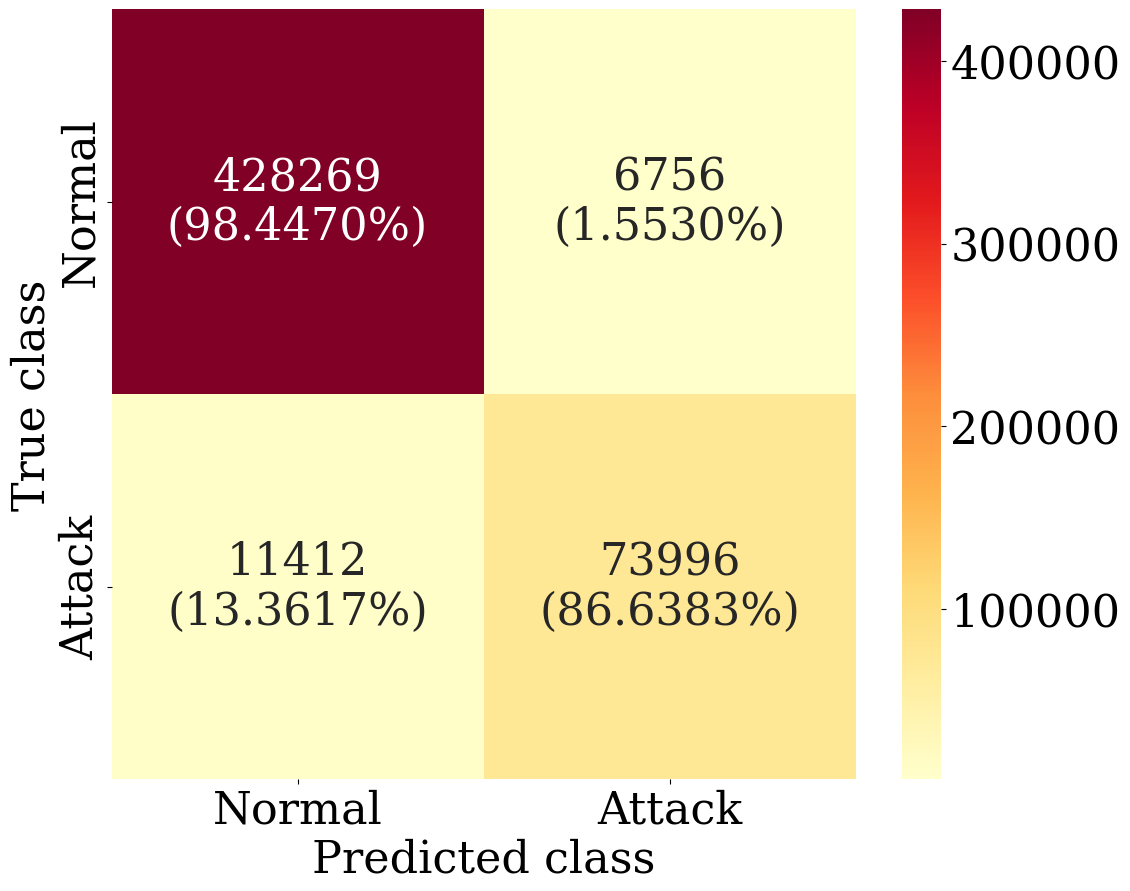

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 32
LABELS = ["Normal", "Attack"]
conf_matrix = confusion_matrix(y_supervised_test, hmfnn_predictions)

# Calculate percentages row-wise
row_sums = conf_matrix.sum(axis=1, keepdims=True)
perc_matrix = conf_matrix / row_sums

# Create annotated labels with counts and row-wise percentages
annot_labels = np.asarray([["{}\n({:.4%})".format(count, perc) for count, perc in zip(row, perc_row)]
                           for row, perc_row in zip(conf_matrix, perc_matrix)])


plt.figure(figsize=( 12, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=annot_labels, fmt='', cmap='YlOrRd');
#plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig("hmfnn_confusion_ids.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# LR and DT

In [ ]:
def get_lr_low_confidence(prediction_probabilities, data, labels, threshold):
  # Get the max probability (confidence score)
  confidence_scores = np.max(prediction_probabilities, axis=1)
  confidence_scores_rounded = np.round(confidence_scores, 2)
  #print(confidence_scores_rounded)
  # Create a mask for low confidence scores
  low_confidence_mask = confidence_scores_rounded <= threshold
  #print(low_confidence_mask)
  # Filter data and labels using the mask
  low_confidence_data = data[low_confidence_mask]
  low_confidence_labels = labels[low_confidence_mask]
  #low_confidence_indexes = data.index[low_confidence_mask] if hasattr(data, 'index') else np.where(low_confidence_mask)[0]
  low_confidence_indexes = data.index[low_confidence_mask]


  high_confidence_probs = prediction_probabilities[~low_confidence_mask]
  high_confidence_indexes = data.index[~low_confidence_mask]

  #return low_confidence_mask
  return high_confidence_probs,high_confidence_indexes, low_confidence_data, low_confidence_labels, low_confidence_indexes

In [ ]:
# Load the model from the file
import joblib

dtc_loaded = joblib.load("/content/drive/MyDrive/SavedHierarchicalModel/cic_ids_2017_dtc.joblib")
#lr_loaded = joblib.load("/content/drive/MyDrive/SavedHierarchicalModel/cic_iot_2023_logistic_regression.joblib")

In [ ]:
tracemalloc.start()
start_time = time.time()
#lr_model_pred = lr_model.predict(x_supervised_test)
lr_pred_probs = lr_loaded.predict_proba(x_supervised_test)
end_time = time.time()
lr_pred_memory_usage = tracemalloc.get_traced_memory()
tracemalloc.stop()
lr_pred_elapsed_time = end_time - start_time
print(f"LR Prediction Time taken: {lr_pred_elapsed_time} seconds")
print("LR Prediction Memory Usage:",(lr_pred_memory_usage[1]-lr_pred_memory_usage[0])/(1024*1024), "MB")

lr_prediction_labels = get_prediction_labels(lr_pred_probs)


accuracy = accuracy_score(y_supervised_test, lr_prediction_labels)
report = classification_report(y_supervised_test, lr_prediction_labels, digits=10)
auc = roc_auc_score(y_supervised_test, lr_prediction_labels)
print("Accuracy:", accuracy)
print("AUC", auc)
print(report)

LR Prediction Time taken: 0.10165286064147949 seconds
LR Prediction Memory Usage: 14.247879981994629 MB
Accuracy: 0.9879440652607657
AUC 0.8615684118534893
              precision    recall  f1-score   support

           0  0.7495064398 0.7289809354 0.7391012121     21873
           1  0.9935032555 0.9941558883 0.9938294648    911858

    accuracy                      0.9879440653    933731
   macro avg  0.8715048476 0.8615684119 0.8664653384    933731
weighted avg  0.9877875383 0.9879440653 0.9878623596    933731



In [ ]:

lr_pred_memory_usage = 27.4216785430908
lr_pred_elapsed_time = 0.0175137519836425

In [ ]:
def evaluate_lr_dt_with_thresholds(m2, m2_pred_probs, m1_pred_memory_usage, m1_pred_time, x_supervised_test, y_supervised_test, thresholds):
    # Initialize a dictionary to hold evaluation results
    results = { 'threshold': [], 'num_low_confidence' : [], 'low_confidence_percentage': [], 'prediction_time': [], 'memory_usage': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

    # Loop over the thresholds to evaluate the model
    for threshold in thresholds:
        print('Current Threshold:', threshold)
        # Get low confidence predictions based on the threshold
        high_probs, high_prob_indexes, m1_low_confidence, low_confidence_labels, low_confidence_indexes = get_lr_low_confidence(lr_pred_probs, x_supervised_test, y_supervised_test, threshold)
        high_prediction_labels = pd.DataFrame(get_prediction_labels(high_probs), index=high_prob_indexes, columns=['Label'])
        print(len(m1_low_confidence))

        # Measure memory usage and prediction time for the m2 model on low confidence samples
        tracemalloc.start()
        start_time = time.time()
        m2_low_pred_probs = m2.predict(m1_low_confidence)
        end_time = time.time()
        m2_low_memory_usage = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Record the time and memory usage
        m2_low_elapsed_time = end_time - start_time
        memory_usage_mb = ((m2_low_memory_usage[1] - m2_low_memory_usage[0]) / (1024 * 1024)) + ((m1_pred_memory_usage[1]-m1_pred_memory_usage[0])/(1024*1024))
        #memory_usage_mb = ((m2_low_memory_usage[1] - m2_low_memory_usage[0]) / (1024 * 1024)) + m1_pred_memory_usage
        # Generate predictions based on FNN low confidence probabilities
        m2_low_pred = pd.DataFrame(np.where(m2_low_pred_probs > 0.5, 1, 0).flatten(), index=low_confidence_indexes, columns=['Label'])
        y_supervised_df = pd.DataFrame(y_supervised_test, columns=['Label'])

        # Rejoin the repredicted with original prediction
        improved_prediction = pd.concat([m2_low_pred, high_prediction_labels], axis=0, ignore_index=False)
        # Match indexes
        improved_pred_reordered = improved_prediction.reindex(y_supervised_df.index)

        # Compute performance metrics
        accuracy = accuracy_score(y_supervised_test, improved_pred_reordered)
        auc = roc_auc_score(y_supervised_test, improved_pred_reordered)
        precision = precision_score(y_supervised_test, improved_pred_reordered, average='macro')
        recall = recall_score(y_supervised_test, improved_pred_reordered, average='macro')
        f1 = f1_score(y_supervised_test, improved_pred_reordered, average='macro')

        # Store results
        results['threshold'].append(threshold)
        results['accuracy'].append(accuracy)
        results['auc'].append(auc)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['prediction_time'].append(m2_low_elapsed_time + m1_pred_time)
        results['memory_usage'].append(memory_usage_mb)
        results['low_confidence_percentage'].append(np.round(((len(m1_low_confidence) / len(x_supervised_test))*100), 5))
        results['num_low_confidence'].append(len(m1_low_confidence))

    return pd.DataFrame(results), improved_pred_reordered

# Define your thresholds
#thresholds = [0.99, 0.98, 0.97, 0.96, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
thresholds = [0.85]

# This function will iterate over each threshold and collect the performance
results_df, hmdt_predictions = evaluate_lr_dt_with_thresholds(dtc_loaded, lr_pred_probs, lr_pred_memory_usage, lr_pred_elapsed_time, x_supervised_test, y_supervised_test, thresholds)

Current Threshold: 0.85
120945


In [ ]:
results_df

,threshold,num_low_confidence,low_confidence_percentage,prediction_time,memory_usage,accuracy,precision,recall,f1,auc
0,0.85,120945,23.2393,0.083238,46.235895,0.988256,0.98882,0.968166,0.978138,0.968166


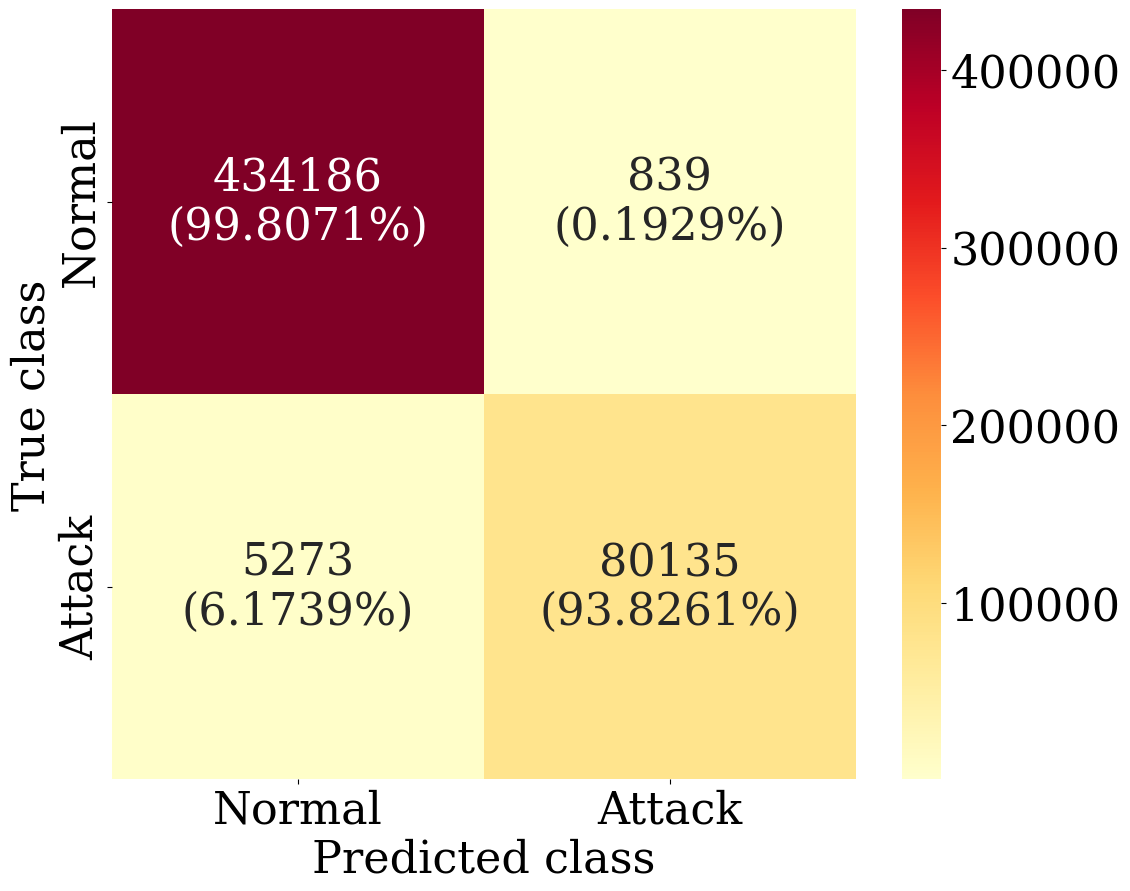

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 32
LABELS = ["Normal", "Attack"]
conf_matrix = confusion_matrix(y_supervised_test, hmdt_predictions)

# Calculate percentages row-wise
row_sums = conf_matrix.sum(axis=1, keepdims=True)
perc_matrix = conf_matrix / row_sums

# Create annotated labels with counts and row-wise percentages
annot_labels = np.asarray([["{}\n({:.4%})".format(count, perc) for count, perc in zip(row, perc_row)]
                           for row, perc_row in zip(conf_matrix, perc_matrix)])


plt.figure(figsize=( 12, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=annot_labels, fmt='', cmap='YlOrRd');
#plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig("hmdt_confusion_ids.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#results_df.to_csv('/content/drive/MyDrive/SavedHierarchicalModel/ModelResults/cic_ids2017_lrDT_results.csv', index=False)

# TOPSIS Pareto-Optimization

# Creating Graphs